<a href="https://colab.research.google.com/github/tomasonjo/blogs/blob/master/llm/neo4j_llama_multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install llama_index neo4j torch torchvision git+https://github.com/openai/CLIP.git beautifulsoup4

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-juyxfiel
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-juyxfiel
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [2]:
import os
from bs4 import BeautifulSoup, NavigableString
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.vector_stores import Neo4jVectorStore
from llama_index import StorageContext, Document
from llama_index.schema import ImageDocument
from llama_index.node_parser import SimpleNodeParser
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
import tiktoken
import seaborn as sns
import requests
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

os.environ["OPENAI_API_KEY"] = "sk-"
NEO4J_URI=""
NEO4J_USERNAME=""
NEO4J_PASSWORD=""

# Multimodal RAG pipeline with LlamaIndex and Neo4j
## Retrieve and combine information from text and images to generate an accurate response with multimodal LLMs


The field of AI and large language models is evolving rapidly. One year ago, nobody ever used an LLM to enhance their productivity. Today, most of us can't imagine working without or not offloading at least some minor tasks to LLMs. Due to much research and interest, LLMs are getting better and wiser every day. Not only that, but their comprehension is starting to span across multiple modalities. With the introduction of GPT-4-Vision and other LLMs that followed it, it seems that LLMs today can tackle and comprehend images very well.

We can use its ability to understand images in an RAG application, where instead of relying only on text to generate an accurate and up-to-date answer, we can now combine information from text and pictures to generate more accurate answers than ever before. Using LlamaIndex, implementing multimodal RAG pipelines is as easy as it gets. Inspired by their multimodal cookbook example, I decided to test if I could implement a multimodal RAG application with Neo4j as the database.
To implement a multimodal RAG pipeline with LlamaIndex, you simply instantiate two vector stores, one for images and one for text, and then query both of them in order to retrieve relevant information to generate the final answer.

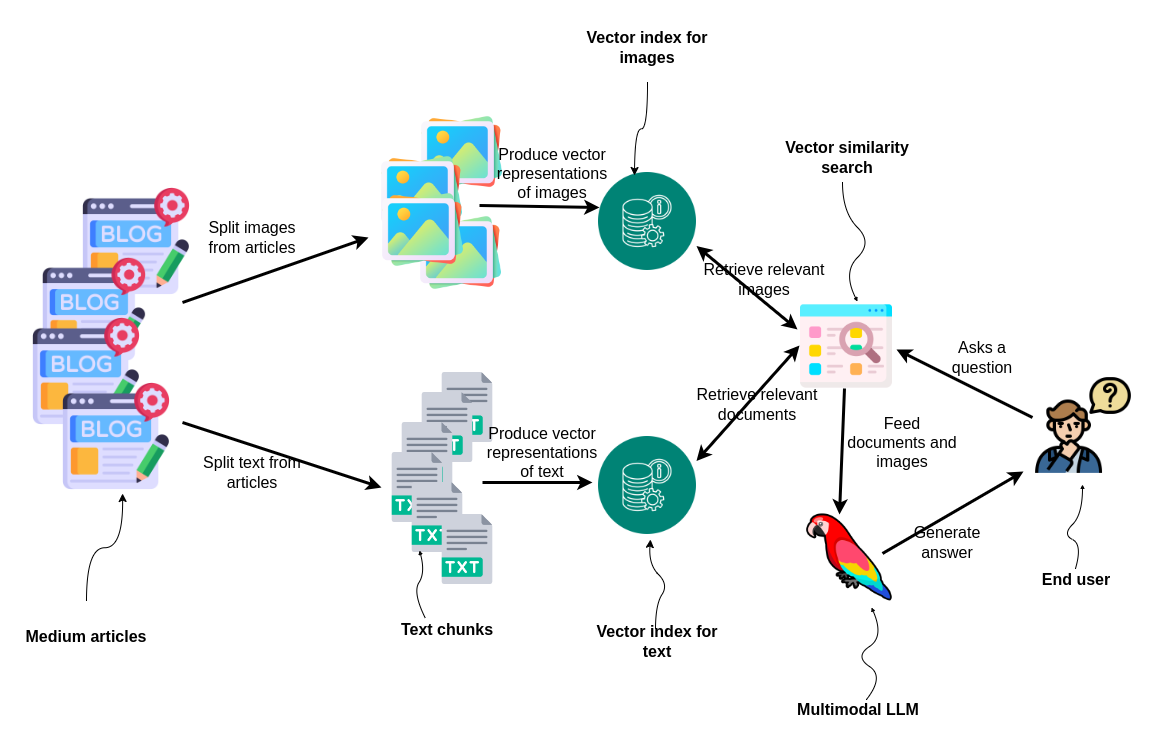

Articles are first split into images and text. These elements are then converted into vector representations and indexed separately. For text we will use ada-002 text embedding model, while for images we will be using dual encoder model CLIP, which can embed both text and images in the same embedding space. When a question is posed by an end user, two vector similarity search are performed; one to find relevant images and the other for documents. The results are fed into a multimodal LLM, which generates an answer for the user, demonstrating an integrated approach to processing and utilizing mixed media for information retrieval and response generation.

## Data preprocessing
We will use my Medium articles from 2022 and 2023 as the grounding dataset for an RAG application. The articles contain vast information about Neo4j Graph Data Science library and combining Neo4j with LLM frameworks

In [3]:
!wget https://github.com/tomasonjo/blog-datasets/raw/main/articles.zip

--2023-12-15 13:55:42--  https://github.com/tomasonjo/blog-datasets/raw/main/articles.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/articles.zip [following]
--2023-12-15 13:55:42--  https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/articles.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347398 (339K) [application/zip]
Saving to: ‘articles.zip.2’

articles.zip.2      100%[===================>] 339.26K  --.-KB/s    in 0.03s   

2023-12-15 13:55:42 (10.4 MB/s) - ‘articles.zip.2’ saved [347398/347398]



In [4]:
!unzip articles.zip

replace 2022-01-10_Exploring-the-NFT-transaction-with-Neo4j-cba80ead7e0b.html? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

When you download your own articles from Medium, you get them in an HTML format. Therefore, we need to employ a bit of coding to extract text and images separately.

In [5]:
def process_html_file(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file, "html.parser")

    # Find the required section
    content_section = soup.find("section", {"data-field": "body", "class": "e-content"})

    if not content_section:
        return "Section not found."

    sections = []
    current_section = {"header": "", "content": "", "source": file_path.split("/")[-1]}
    images = []
    header_found = False

    for element in content_section.find_all(recursive=True):
        if element.name in ["h1", "h2", "h3", "h4"]:
            if header_found and (current_section["content"].strip()):
                sections.append(current_section)
            current_section = {
                "header": element.get_text(),
                "content": "",
                "source": file_path.split("/")[-1],
            }
            header_found = True
        elif header_found:
            if element.name == "pre":
                current_section["content"] += f"```{element.get_text().strip()}```\n"
            elif element.name == "img":
                img_src = element.get("src")
                img_caption = element.find_next("figcaption")
                caption_text = img_caption.get_text().strip() if img_caption else ""
                images.append(ImageDocument(image_url=img_src))
            elif element.name in ["p", "span", "a"]:
                current_section["content"] += element.get_text().strip() + "\n"

    if current_section["content"].strip():
        sections.append(current_section)

    return images, sections

I won't go into details for the parsing code, but we split the text based on headers h1–h4 and extract image links. Then, we simply run all the articles through this function to extract all relevant information.

In [6]:
all_documents = []
all_images = []

# Directory to search in (current working directory)
directory = os.getcwd()

# Walking through the directory
for root, dirs, files in os.walk(directory):
    for file in files:
        if file.endswith(".html"):
            # Update the file path to be relative to the current directory
            images, documents = process_html_file(os.path.join(root, file))
            all_documents.extend(documents)
            all_images.extend(images)

text_docs = [Document(text=el.pop("content"), metadata=el) for el in all_documents]
print(f"Text document count: {len(text_docs)}")
print(f"Image document count: {len(all_images)}")

Text document count: 252
Image document count: 328


We get a total of 252 text chunks and 328 images. It's a bit surprising that I created so many photos, but I know that some are only images of table results. We could use a vision model to filter out irrelevant photos, but I skipped this step here.
## Indexing data vectors
As mentioned, we have to instantiate two vector stores, one for images and the other for text. The CLIP embedding model has a dimension of 512, while the ada-002 has 1536 dimension.

In [7]:
text_store = Neo4jVectorStore(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    index_name="text_collection",
    node_label="Chunk",
    embedding_dimension=1536
)
image_store = Neo4jVectorStore(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    index_name="image_collection",
    node_label="Image",
    embedding_dimension=512

)
storage_context = StorageContext.from_defaults(vector_store=text_store)

Now that the vector stores have been initiated, we use the MultiModalVectorStoreIndex to index both modalities of information we have.

In [8]:
# Takes 10 min without GPU / 1 min with GPU on Google collab
index = MultiModalVectorStoreIndex.from_documents(
    text_docs + all_images, storage_context=storage_context, image_vector_store=image_store
)

Under the hood, MultiModalVectorStoreIndex uses text and image embedding models to calculate the embeddings and store and index the results in Neo4j. Only the URLs are stored for images, not actual base64 or other representations of images.
## Multimodal RAG pipeline
This piece of code is copied directly from the LlamaIndex multimodal cookbook. We begin by defining a multimodal LLM and the prompt template and then combine everything as a query engine.

In [9]:
from llama_index.prompts import PromptTemplate
from llama_index.query_engine import SimpleMultiModalQueryEngine

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", max_new_tokens=1500
)


qa_tmpl_str = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    multi_modal_llm=openai_mm_llm, text_qa_template=qa_tmpl
)

query_str = "How do vector RAG application work?"
response = query_engine.query(query_str)
print(response)

Vector Retrieval-Augmented Generation (RAG) applications work by combining the capabilities of large language models (LLMs) with vector search technology to provide accurate and contextually relevant answers to queries. Here's a step-by-step explanation based on the provided image:

1. **Text Chunking**: The process begins with a large corpus of text, such as a Wikipedia article. This text is broken down into smaller, more manageable chunks.

2. **Produce Vector Representations of Text**: Each text chunk is then processed to produce a vector representation. This involves converting the text into a high-dimensional space where semantically similar pieces of text are represented by vectors that are close to each other.

3. **Neo4j Vector Index**: These vector representations are stored in a vector index within a database like Neo4j. Neo4j's recent addition of vector index search capability allows it to efficiently store and retrieve these vector representations.

4. **Vector Similarity S

We can also visualize which images the retrieval fetched and were used to help inform the final answer.

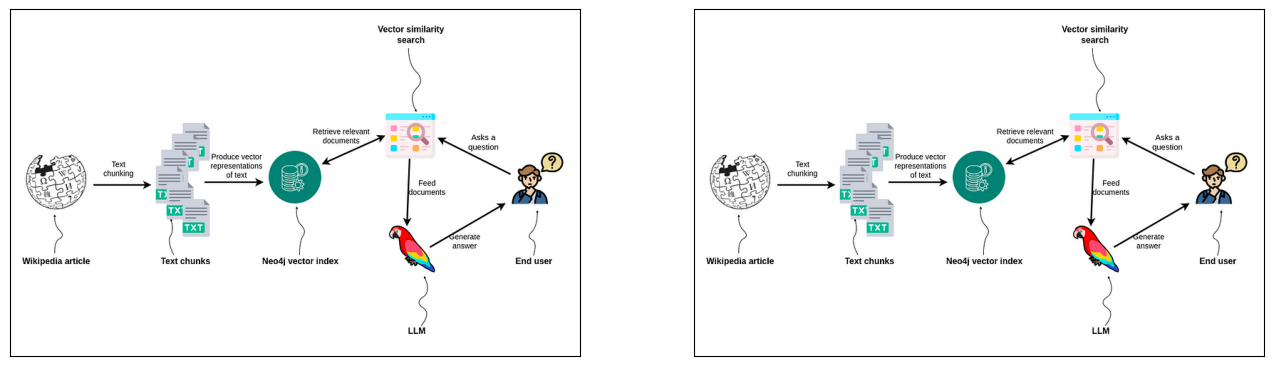

In [10]:
def plot_images(image_urls):
    images_shown = 0
    plt.figure(figsize=(25, 15))
    for img_url in image_urls:
        try:
            response = requests.get(img_url)
            response.raise_for_status()  # Raise an error for bad status codes
            image = Image.open(BytesIO(response.content))

            plt.subplot(1, 3, images_shown + 1)  # Layout adjusted for 3 images
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 4:  # Break after displaying 3 images
                break
        except Exception as e:
            print(f"Error loading image {img_url}: {e}")

plot_images([n.node.image_url for n in response.metadata["image_nodes"]])

The LLM got two identical images as input, which just shows that I reuse some of my diagrams. However, I am pleasantly surprised by CLIP embeddings as they were able to retrieve he most relevant image out of the collection. In a more production setting, you might want to clean and deduplicate images, but that is beyond the scope of this article.
## Conclusion
LLMs are evolving faster than what we are historically used to and are spanning across multiple modalities. I firmly believe that by the end of the next year, LLMs will be soon able to comprehend videos, and be therefore able to pick up non-verbal cues while talking to you. On the other hand, we can use images as input to RAG pipeline and enhance the variety of information passed to an LLM, making responses better and more accurate. The multimodal RAG pipelines implementation with LlamaIndex and Neo4j is as easy as it gets.